# Exploratory Data Analysis

# Imports, Read-in

In [1]:
# Data manip.
import pandas as pd
import numpy as np

# Vizz
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# scikit-learn
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
# nltk.download('stopwords')
sw = stopwords.words('english')

# etc.
import sys
sys.path.append( '../src' )
from parse_it import *

The data is stored in two separate `.csv` files.

In [2]:
df_good = pd.read_csv('../../data/good.csv')
df_promo = pd.read_csv('../../data/promotional.csv')

Taking a look at a sample article from the `promotional` articles dataset.

In [3]:
df_good.iloc[999].text[:1000]

"The 2007 Bernard Matthews H5N1 outbreak was an occurrence of avian influenza in England caused by the H5N1 subtype of Influenza virus A that began on 30 January 2007. The infection affected poultry at one of Bernard Matthews' farms in Holton in Suffolk. It was the third instance of H5N1 subtype detected in the United Kingdom and a range of precautions were instituted to prevent spread of the disease including a large cull of turkeys, the imposition of segregation zones, and a disinfection programme for the plant. The cause of the outbreak was not determined. However, it was considered significant that Bernard Matthews regularly transports turkeys and turkey products between the UK and its plant in Hungary, and that the H5N1 strains previously found in Hungary, and those found at Suffolk, were effectively genetically identical. H5N1 is a subtype of the Influenza A virus, the viruses responsible for influenza in humans and many other animal species. A bird adapted strain of H5N1, called

Testing out a custom function, `parse_doc`, which takes care of several NLP preprocessing steps: lowercasing, punctuation and character stripping, lemmatizing, and removing stopwords. It returns a string of *non-unique lemmas*, but can also return a list by setting the argument `as_list = True`. If stemming is preferred to lemmatizing, this can also be done within the function: `stem = 'stem'`.

In [4]:
parse_doc( df_good.iloc[999].text )

'bernard matthews h n outbreak occurrence avian influenza england cause h n subtype influenza virus begin january infection affect poultry one bernard matthews farm holton suffolk third instance h n subtype detect united kingdom range precaution institute prevent spread disease include large cull turkey imposition segregation zone disinfection programme plant cause outbreak determine however consider significant bernard matthew regularly transport turkey turkey product uk plant hungary h n strain previously find hungary find suffolk effectively genetically identical h n subtype influenza virus viruses responsible influenza human many animal specie bird adapt strain h n call hpai h n highly pathogenic avian influenza virus type subtype h n causative agent h n flu hpai h n consider avian disease although evidence limit human human transmission virus risk factor contract virus handle infected poultry transmission virus infect bird human inefficient poultry farming practice change due h n 

# Sample Size, Scope, and Content

In [5]:
print(df_good.shape)
print(df_promo.shape)

(30279, 2)
(23837, 7)


In [6]:
df_good.shape[0] + df_promo.shape[0]

54116

In terms of **rows/records**,
- The dataframe containing **"good"** articles has 30,279 entries.
- The dataframe containing **"promotional"** articles has 23,837 entries.

Combined, we have **54,116** articles for examination.

Next, let's discuss features/columns.

In [7]:
print(df_good.columns)
print(df_promo.columns)

Index(['text', 'url'], dtype='object')
Index(['text', 'advert', 'coi', 'fanpov', 'pr', 'resume', 'url'], dtype='object')


- The dataframe containing **"good"** articles has 2 columns - `text` and `url`.
- The dataframe containing **"promotional"** articles has 7 columns - in addition to `text` and `url`, there are five subtypes of "promotional tone":

    - `advert`: The article reads like an advertisement.
    - `coi`: The article appears to have been written by someone with a close connection to the subject.
    - `fanpov`: The article appears to have been written from a fan's point of view, rather than a neutral point of view.
    - `pr`: The article reads like a press release/news article.
    - `resume`: The (biographical) article reads like a résumé, i.e. it is neither neutral nor encylopedic in nature.
    
    The values contained in these columns are one-hot encoded binary values. See the dataframe heads below for a tabular representation of the data.

In [8]:
df_good.head(3)

,text,url
0,Nycticebus linglom is a fossil strepsirrhine p...,https://en.wikipedia.org/wiki/%3F%20Nycticebus...
1,Oryzomys pliocaenicus is a fossil rodent from ...,https://en.wikipedia.org/wiki/%3F%20Oryzomys%2...
2,.hack dt hk is a series of single player actio...,https://en.wikipedia.org/wiki/.hack%20%28video...


In [9]:
df_promo.head(3)

,text,advert,coi,fanpov,pr,resume,url
0,"1 Litre no Namida 1, lit. 1 Litre of Tears als...",0,0,1,0,0,https://en.wikipedia.org/wiki/1%20Litre%20no%2...
1,"1DayLater was free, web based software that wa...",1,1,0,0,0,https://en.wikipedia.org/wiki/1DayLater
2,1E is a privately owned IT software and servic...,1,0,0,0,0,https://en.wikipedia.org/wiki/1E


### Side Investigation: Average Length of Articles?

In [10]:
print(len(df_good.iloc[0].text))
print(len(df_good.iloc[0].text.split()))

3466
590


In [11]:
df_good.text.str.len()

0         3466
1         3230
2        22691
3         5620
4         9303
         ...  
30274    32625
30275     6667
30276     9625
30277    15576
30278    11186
Name: text, Length: 30279, dtype: int64

In [12]:
df_promo.text.str.len()

0         3439
1         1546
2         5550
3        11461
4         1300
         ...  
23832      895
23833     2677
23834     1306
23835     4642
23836     2946
Name: text, Length: 23837, dtype: int64

In [18]:
avg_char_good = df_good.text.str.len().mean()
avg_char_promo = df_promo.text.str.len().mean()

In [14]:
split_words_good = df_good.text.str.split()
split_words_promo = df_promo.text.str.split()

In [16]:
word_count_good = 0

for article in split_words_good:
    word_count_good += len(article)
    
avg_words_good = word_count_good / len(split_words_good)

print(avg_words_good)

2628.5815581756333


In [17]:
word_count_promo = 0

for article in split_words_promo:
    word_count_promo += len(article)
    
avg_words_promo = word_count_promo / len(split_words_promo)

print(avg_words_promo)

768.2722658052608


In [19]:
print(f"Average 'good' article length: {avg_char_good:.0f} characters, {avg_words_good:.0f} words")
print(f"Average 'promotional' article length: {avg_char_promo:.0f} characters, {avg_words_promo:.0f} words")

Average 'good' article length: 15649 characters, 2629 words
Average 'promotional' article length: 4771 characters, 768 words


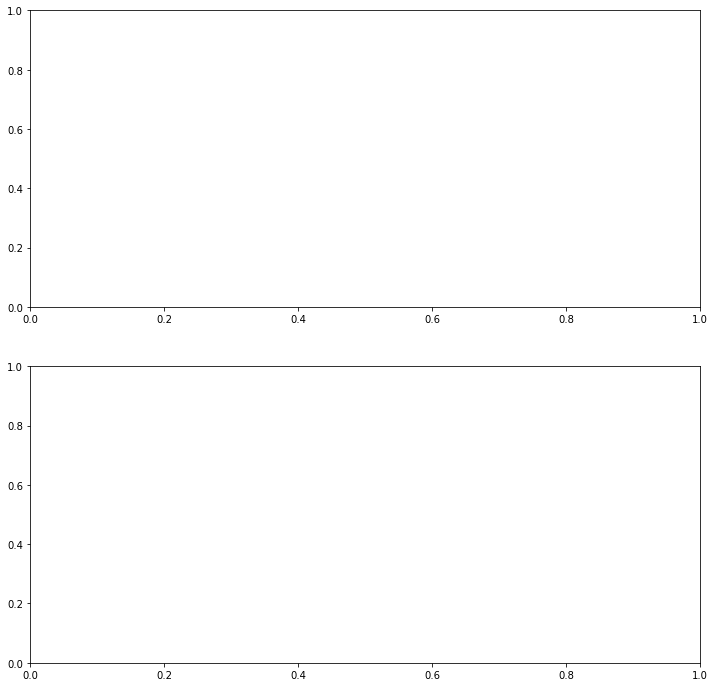

In [21]:
# Visualization of average lengths

fig, ax = plt.subplots(nrows=2,
                       ncols=1,
                       figsize=(12, 12))

# ax[0].barh()

# ax[1].barh()

## Checking for Nulls / Data Types

In [ ]:
df_good.info()

In [ ]:
df_promo.info()

## Value Counts for Subclasses

Knowing there are five different subtypes of promotional article indicated within the dataset raises a further question: *how are those subtypes distributed?*

In [ ]:
df_promo.select_dtypes(include='number').columns

In [ ]:
# class_cols = df_promo.select_dtypes(include='number').columns
class_cols = df_promo.select_dtypes(include='number').columns.tolist()

class_cols

In [ ]:
for col in class_cols:
    print(f"{df_promo[[col]].value_counts(normalize=True)}\n")

In [ ]:
df_promo.columns

In [ ]:
fig, ax = plt.subplots(nrows=1,
                       ncols=5,
                       figsize=(30,6))

ax[0].bar(x=df_promo['advert'].value_counts(normalize=True).index,
          height=df_promo['advert'].value_counts(normalize=True).values,
          tick_label=['True', 'False'])
ax[0].set_title("Advertisement-like")

ax[1].bar(x=df_promo['coi'].value_counts(normalize=True).index,
          height=df_promo['coi'].value_counts(normalize=True).values,
          tick_label=['False', 'True'])
ax[1].set_title("Conflict of interest")

ax[2].bar(x=df_promo['fanpov'].value_counts(normalize=True).index,
          height=df_promo['fanpov'].value_counts(normalize=True).values,
          tick_label=['False', 'True'])
ax[2].set_title("Written from fan's point of view")

ax[3].bar(x=df_promo['pr'].value_counts(normalize=True).index,
          height=df_promo['pr'].value_counts(normalize=True).values,
          tick_label=['False', 'True'])
ax[3].set_title("Written like a news article/press release")

ax[4].bar(x=df_promo['resume'].value_counts(normalize=True).index,
          height=df_promo['resume'].value_counts(normalize=True).values,
          tick_label=['False', 'True'])
ax[4].set_title("Reads like a résumé");

# Set-up for Simple Binary Classification

First, we drop all columns but `text`, which will be our primary feature.

In [ ]:
df_good = df_good[['text']]
df_promo = df_promo[['text']]

Before concatening the simplified dataframes, I create a new column `label` in each dataframe and give it the same value in every row. In `df_good`, each row is given the label `0` to indicate `False`, i.e. the article does ***not*** have a promotional tone. Conversely, each row in `df_promo` is given the label `1` to represent `True`, that the article ***does*** contain content that is promotional in tone.

Multi-class classification is explored in a [separate notebook](Multi-label.ipynb).

In [ ]:
df_good['label'] = 0
df_good.head(3)

In [ ]:
df_promo['label'] = 1
df_promo.head(3)

Next, we concatenate the dataframes using the pandas method `.append` - setting `ignore_index` to `True` means that the unique index values from `df_promo` are not carried over when this dataframe is appended to `df_good`; the indexing, rather, continues where `df_good`'s index leaves off.

In [ ]:
df = df_good.append(other=df_promo,
                    ignore_index=True)

df

In [ ]:
df = df.sample(frac = 1).reset_index(drop=True)

df

In [ ]:
# freq_out(df, 'text', 10)

In [ ]:
df['text'][:100].apply(parse_doc)

In [ ]:
df

# Modeling Setup/Brainstorming

## `DummyClassifier`

## `DecisionTreeClassifier`

## `MultinomialNB`

## `RandomForestClassifier`

## `GradientBoostingClassifier`

## `XGBRFClassifier`